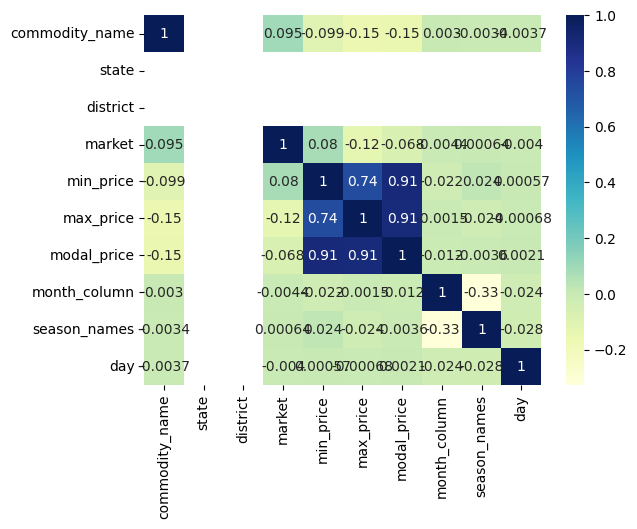

R2 Score: 0.8683059066348351
Mean Squared Error (MSE): 38.012383103325654
Root Mean Squared Error (RMSE): 6.165418323465623
Mean Absolute Error (MAE): 3.908383953410666


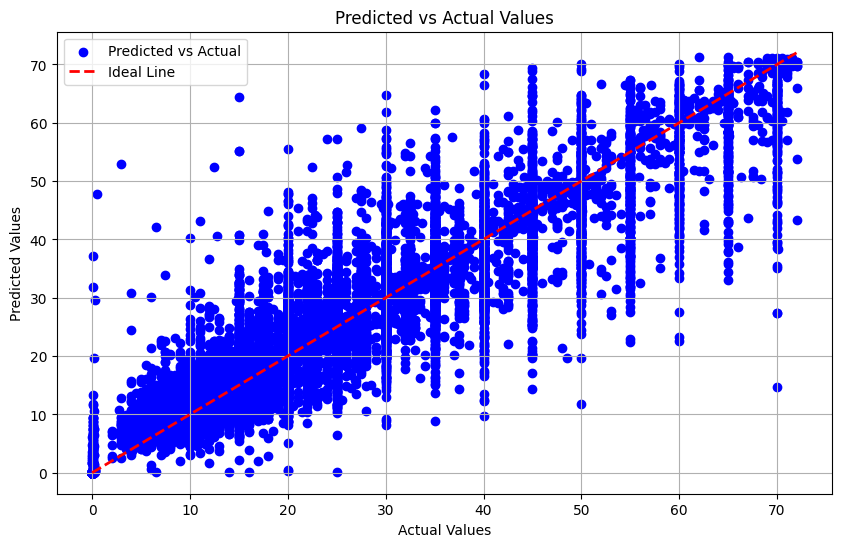

Prediction for user input: [42.1605]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load the data
df = pd.read_csv('/content/New Dataset.csv')
# Convert prices from per quintal to per kilogram
df['min_price'] = df['min_price'] / 100
df['max_price'] = df['max_price'] / 100
df['modal_price'] = df['modal_price'] / 100

# Extract month and season
Dict = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
        7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"}
month_column = [Dict[int(date.split('-')[1])] for date in df["date"]]
df["month_column"] = month_column

# Map months to seasons
season_names = []
for month in df["month_column"]:
    if month in ["January", "February"]:
        season_names.append("winter")
    elif month in ["March", "April"]:
        season_names.append("spring")
    elif month in ["May", "June"]:
        season_names.append("summer")
    elif month in ["July", "August"]:
        season_names.append("monsoon")
    elif month in ["September", "October"]:
        season_names.append("autumn")
    else:
        season_names.append("pre winter")
df["season_names"] = season_names

# Add day of the week
day_of_week = [pd.Timestamp(date).dayofweek for date in df["date"]]
df['day'] = day_of_week

# Drop original date column
df = df.drop("date", axis=1)

# Remove outliers
Q1 = np.percentile(df['modal_price'], 25)
Q3 = np.percentile(df['modal_price'], 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['modal_price'] > lower_bound) & (df['modal_price'] < upper_bound)]

# Encode categorical features
label_encoders = {}
for column in ['commodity_name', 'state', 'district', 'market', 'month_column', 'season_names']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Plot correlation heatmap
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

# Features and Labels
features = df[['commodity_name','state','district','market','month_column','season_names','day']]
labels = df['modal_price']

# Train-test split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features, labels, test_size=0.2, random_state=2)

# Model Training
regr = RandomForestRegressor(max_depth=1000, random_state=0)
regr.fit(Xtrain, Ytrain)

# Prediction and Evaluation
y_pred = regr.predict(Xtest)
print("R2 Score:", r2_score(Ytest, y_pred))

# Calculate evaluation metrics
mse = mean_squared_error(Ytest, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Ytest, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(Ytest, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([Ytest.min(), Ytest.max()], [Ytest.min(), Ytest.max()], '--', color='red', linewidth=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Example prediction
user_input = [[1, 1, 1, 1, 1, 1, 3]]
user_input = np.array(user_input).reshape(1, -1)
print("Prediction for user input:", regr.predict(user_input))
